In [64]:
#================ Importing the data from CSV with pandas ===========
import pandas as pd
from sklearn import tree
import numpy as np
from sklearn.tree import export_graphviz

titanic_data = pd.read_csv('Titanic.csv')

titanic_data['age'].fillna(titanic_data['age'].mean(), inplace = True)
titanic_data.drop(columns=['Unnamed: 0'], inplace=True)
titanic_data.info()
titanic_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null object
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1309 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 143.3+ KB


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [65]:
#Create Training and Test sets
from random import sample

data_points = titanic_data.shape[0]

training_list = sample(range(data_points), int(0.7*data_points))

training_set = None
test_set = None

for i in range(0,data_points):
    if i in training_list:
        #append to training set
        if training_set is None:
            training_set = titanic_data.iloc[[i]]
        else:
            training_set = training_set.append(titanic_data.iloc[i])
    else:
        #append to test set
        if test_set is None:
            test_set = titanic_data.iloc[[i]]
        else:
            test_set = test_set.append(titanic_data.iloc[i])

#Check for valid split of data
train_size_b4 = training_set.shape[0]
training_set.drop_duplicates(inplace=True)
train_size_af = training_set.shape[0]

if ((train_size_b4 == train_size_af) and ((training_set.shape[0] + test_set.shape[0]) == data_points)):
    print("GOOD SPLIT")
    
training_set.head(7)

GOOD SPLIT


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
2,1st,0,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
6,1st,1,"Andrews, Miss. Kornelia Theodos",female,63.0,1,0,13502,77.958298,D7,Southampton,10,NaN,"Hudson, NY"
7,1st,0,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.000000,A36,Southampton,NaN,NaN,"Belfast, NI"
8,1st,1,"Appleton, Mrs. Edward Dale (Cha",female,53.0,2,0,11769,51.479198,C101,Southampton,D,NaN,"Bayside, Queens, NY"


In [66]:
#=========== Format Test and Training sets ========================
#Replace String Types with integers for decision tree fitting
replace_sex = {'female': int(0), 'male': int(1)}
replace_pclass = {'1st':int(0), '2nd':int(1), '3rd':int(2)}

training_set[['pclass']] = training_set[['pclass']].replace(replace_pclass)
training_set[['sex']] = training_set[['sex']].replace(replace_sex)

test_set[['pclass']] = test_set[['pclass']].replace(replace_pclass)
test_set[['sex']] = test_set[['sex']].replace(replace_sex)

features = ['pclass', 'sex', 'age', 'sibsp']
target = 'survived'

X = training_set[features]
Y = training_set[target]

X_test = test_set[features]
Y_test = test_set[target]

In [84]:
#================= Train Decision Tree =============================
from sklearn.externals.six import StringIO   
import pydotplus

def create_tree_png(tree_model, output_file):
    dot_data = StringIO()
    export_graphviz(tree_model, out_file=dot_data, filled=True, rounded=True, special_characters=True,feature_names = features)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(output_file)

dec_tree = tree.DecisionTreeClassifier()
trained = dec_tree.fit(X,Y)
create_tree_png(trained, 'output_data/titanic_tree_new.png')

In [85]:
#=============== Print out Accuracy metrics =======================
def construct_confusion(truth, prediction):
    #Construct Confusion matrix
    confusion = np.array([[0,0],[0,0]])
    for i in range(0, len(truth)):
        if (truth[i] == 0):
            if prediction[i] == 0:
                confusion[0,0] += 1
            else:
                confusion[0,1] += 1
        else:
            if prediction[i] == 0:
                confusion[1,0] += 1
            else:
                confusion[1,1] += 1
                
    return confusion/len(truth)

def print_confusion(confusion):
    print("\n   Predicted Class")
    print("      0  |   1")
    print("0 | %.2f | %.2f |"%(confusion[0,0], confusion[0,1]))
    print("1 | %.2f | %.2f |\n"%(confusion[1,0], confusion[1,1]))
    
prediction = trained.predict(X)
truth = Y.to_numpy()
diff = truth - prediction

confusion_train = construct_confusion(truth, prediction)

print("Training Accuracy: %.2f%%"%(100 - np.sum(np.abs(diff))*100/len(truth)))
print_confusion(confusion_train)

prediction = trained.predict(X_test)
truth = Y_test.to_numpy()
diff = truth - prediction

confusion_test = construct_confusion(truth, prediction)

print("Test Accuracy: %.2f%%"%(100 - np.sum(np.abs(diff))*100/len(truth)))
print_confusion(confusion_test)

print("In-Sample Percent Survivor: %.2f%%"%((confusion_train[1,1]*100)/(confusion_train[1,1]+confusion_train[1,0])))
print("In-Sample Percent Fatality: %.2f%%"%((confusion_train[0,0]*100)/(confusion_train[0,1]+confusion_train[0,0])))
print("Out-Sample Percent Survivor: %.2f%%"%((confusion_test[1,1]*100)/(confusion_test[1,1]+confusion_test[1,0])))
print("Out-Sample Percent Fatality: %.2f%%"%((confusion_test[0,0]*100)/(confusion_test[0,1]+confusion_test[0,0])))


Training Accuracy: 88.32%

   Predicted Class
      0  |   1
0 | 0.59 | 0.03 |
1 | 0.09 | 0.29 |

Test Accuracy: 78.12%

   Predicted Class
      0  |   1
0 | 0.52 | 0.10 |
1 | 0.12 | 0.26 |

In-Sample Percent Survivor: 76.42%
In-Sample Percent Fatality: 95.74%
Out-Sample Percent Survivor: 68.24%
Out-Sample Percent Fatality: 84.08%


Averages: 
	Train: 11.47%
	Test: 26.69%


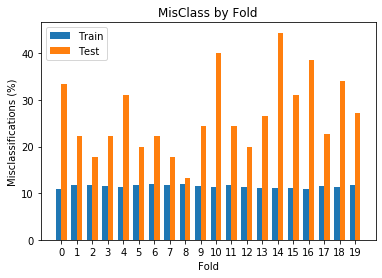

In [95]:
#Create Cross Validation Frame Work and Display functionality of it
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def cross_validate(X,Y,n_folds, decision_tree):

    misclassifications = []
    cnt = 0
    kf = KFold(n_splits = n_folds)
    for train_index, test_index in kf.split(X):
        cnt += 1
        #print("============= FOLD %d =============="%(cnt))
        #Create Test And Train Folds
        #print("TEST: [%d, %d)"%(min(test_index), max(test_index)))
        X_k_test = X.iloc[min(test_index):max(test_index)]
        Y_k_test = Y.iloc[min(test_index):max(test_index)]

        X_k = pd.DataFrame({'A' : []})
        Y_k = pd.DataFrame({'A' : []})
        if (min(test_index) > 0):
            #print("\tTRAIN: [%d, %d) "%(0, min(test_index)))
            X_k = X.iloc[0:min(test_index)]
            Y_k = Y.iloc[0:min(test_index)]

        if (max(test_index) < X.shape[0]-1):
            #print("\tTRAIN: [%d, %d) "%(max(test_index), X.shape[0]))
            if X_k.empty:
                X_k = X.iloc[max(test_index):(X.shape[0])]
            else:
                X_k = X_k.append(X.iloc[max(test_index):(X.shape[0])])

            if Y_k.empty:
                Y_k = Y.iloc[max(test_index):(Y.shape[0])]
            else:
                Y_k = Y_k.append(Y.iloc[max(test_index):(Y.shape[0])])

        #print("X_k: ", X_k.shape[0], "| Y_k: ",Y_k.shape[0] )
        #print("X_k_test: ", X_k_test.shape[0], " | Y_k_test: ", Y_k_test.shape[0], '\n')

        k_trained = decision_tree.fit(X_k, Y_k)

        prediction = k_trained.predict(X_k)
        truth = Y_k.to_numpy()
        diff = truth - prediction
        perc_mis_train = np.sum(np.abs(diff))*100/len(truth)

        prediction = k_trained.predict(X_k_test)
        truth = Y_k_test.to_numpy()
        diff = truth - prediction
        perc_mis_test = np.sum(np.abs(diff))*100/len(truth)

        misclassifications.append([perc_mis_train, perc_mis_test])
        #print("\nPercent Train Mis: %.2f%%"%(perc_mis_train))
        #print("Percent Test  Mis: %.2f%%"%(perc_mis_test))
        #print("\n")
        
    return misclassifications
    
mis_nump = np.array(cross_validate(X,Y,20, dec_tree))
print("Averages: ")
print("\tTrain: %.2f%%"%(np.sum(mis_nump, axis=0)[0]/len(mis_nump[:,0])))
print("\tTest: %.2f%%"%(np.sum(mis_nump, axis=0)[1]/len(mis_nump[:,0])))
train = mis_nump[:,0].tolist()
test = mis_nump[:,1].tolist()
folds = [x for x in range(len(train))]

#Plotting Data By Fold
width = 0.35
pos1 = np.arange(len(train))
pos2 = [x + width for x in pos1]

plt.bar(pos1, train, width=width, label='Train')
plt.bar(pos2, test, width=width, label='Test')

plt.ylabel('Misclassifications (%)')
plt.xlabel('Fold')
plt.xticks([r + width/2 for r in range(len(train))], folds)
plt.title('MisClass by Fold')
plt.legend()

plt.show()
    
    


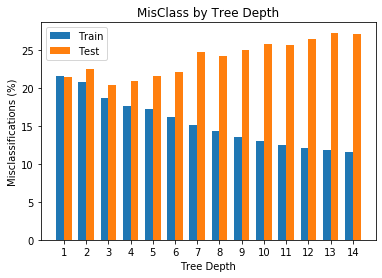

In [91]:
#Select Best Value for Max Tree Depth With 10-fold cross validation
train_acc = []
test_acc = []
depth = []

for max_depth in range(1,15):
    depth.append(max_depth)
    
    decision_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=max_depth)
    
    mis_nump = np.array(cross_validate(X,Y,10, decision_tree))
    
    train_ave = np.sum(mis_nump, axis=0)[0]/len(mis_nump[:,0])
    test_ave = np.sum(mis_nump, axis=0)[1]/len(mis_nump[:,0])
    
    train_acc.append(train_ave)
    test_acc.append(test_ave)

#Plotting Data By Depth
width = 0.35
pos1 = np.arange(len(train_acc))
pos2 = [x + width for x in pos1]

plt.bar(pos1, train_acc, width=width, label='Train')
plt.bar(pos2, test_acc, width=width, label='Test')

plt.ylabel('Misclassifications (%)')
plt.xlabel('Tree Depth')
plt.xticks([r + width/2 for r in range(len(train_acc))], depth)
plt.title('MisClass by Tree Depth')
plt.legend()

plt.show()


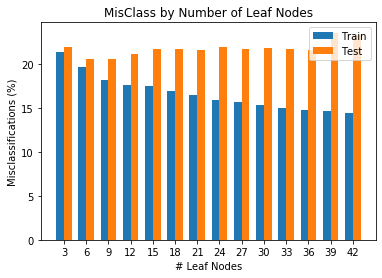

In [93]:
#Select Best Value for Max Leaf Nodes With 10-fold cross validation
train_acc = []
test_acc = []
depth = []

for max_leaf in range(1,15):
    depth.append(3*max_leaf)
    
    decision_tree = tree.DecisionTreeClassifier(criterion='gini', max_leaf_nodes=3*max_leaf)
    
    mis_nump = np.array(cross_validate(X,Y,10, decision_tree))
    
    train_ave = np.sum(mis_nump, axis=0)[0]/len(mis_nump[:,0])
    test_ave = np.sum(mis_nump, axis=0)[1]/len(mis_nump[:,0])
    
    train_acc.append(train_ave)
    test_acc.append(test_ave)

#Plotting Data By Depth
width = 0.35
pos1 = np.arange(len(train_acc))
pos2 = [x + width for x in pos1]

plt.bar(pos1, train_acc, width=width, label='Train')
plt.bar(pos2, test_acc, width=width, label='Test')

plt.ylabel('Misclassifications (%)')
plt.xlabel('# Leaf Nodes')
plt.xticks([r + width/2 for r in range(len(train_acc))], depth)
plt.title('MisClass by Number of Leaf Nodes')
plt.legend()

plt.show()

## Optimal Parameter Selection
### Max Depth
    As Shown above, as max_depth increases, the accuracy of the model on the test day decreases steadily, seeming to asymptotically approach about 10%. However, the accuracy on the test set also steadily increases. Therefore, the best choice would be one that provides the best performance for both the test set and the training set.
    Best Choice = 3
    
### Max Leaf Nodes
    Much like Max Depth, training misclassifactions decrease while test misclassifications increase as max leaf nodes increases. Therefore the best choice is the value that minimizes both.
    Best Choice = 9
    
### Overall
    Of the two parameters above, either are acceptable as both give very similar performance. I will select max_leaf_nodes as the optimal parameter though as that gives more freedom to the shape of the graph.

In [100]:
optimal_tree = tree.DecisionTreeClassifier(criterion='gini', max_leaf_nodes=9)
optimal_trained = optimal_tree.fit(X,Y)

prediction = optimal_trained.predict(X)
truth = Y.to_numpy()
diff = truth - prediction

confusion_train = construct_confusion(truth, prediction)

print("========= OPTIMAL TREE PERFORMANCE ============")
print("Training Accuracy: %.2f%%"%(100 - np.sum(np.abs(diff))*100/len(truth)))
print_confusion(confusion_train)

prediction = optimal_trained.predict(X_test)
truth = Y_test.to_numpy()
diff = truth - prediction

confusion_test = construct_confusion(truth, prediction)

print("Test Accuracy: %.2f%%"%(100 - np.sum(np.abs(diff))*100/len(truth)))
print_confusion(confusion_test)

print("In-Sample Percent Survivor: %.2f%%"%((confusion_train[1,1]*100)/(confusion_train[1,1]+confusion_train[1,0])))
print("In-Sample Percent Fatality: %.2f%%"%((confusion_train[0,0]*100)/(confusion_train[0,1]+confusion_train[0,0])))
print("Out-Sample Percent Survivor: %.2f%%"%((confusion_test[1,1]*100)/(confusion_test[1,1]+confusion_test[1,0])))
print("Out-Sample Percent Fatality: %.2f%%"%((confusion_test[0,0]*100)/(confusion_test[0,1]+confusion_test[0,0])))

create_tree_png(optimal_trained, 'output_data/titanic_tree_optimal.png')


========= OPTIMAL TREE PERFORMANCE ============
Training Accuracy: 81.88%

   Predicted Class
      0  |   1
0 | 0.54 | 0.07 |
1 | 0.11 | 0.28 |

Test Accuracy: 79.13%

   Predicted Class
      0  |   1
0 | 0.54 | 0.09 |
1 | 0.12 | 0.25 |

In-Sample Percent Survivor: 71.88%
In-Sample Percent Fatality: 88.12%
Out-Sample Percent Survivor: 67.57%
Out-Sample Percent Fatality: 86.12%


### Full Tree vs Optimally Pruned
    While the training set accuracy decreased, the test set accuracy did increase slightly with the out-sample fatality measure. As the test accuracy is normally more important than training accuracy, I would say the model is slightly improved from pruning and in the least, significantly less complex 